# Maven Reward Challenge
I’ll play the role of a Sr. Marketing Analyst at Maven Cafe.

Over a 30-day period, Maven Cafe tested different types of offers with Rewards members.

Now that the 30-day period for the test has concluded, my task is to identify key customer segments and develop a data-driven strategy for future promotional messaging & targeting.

Data that simulates the behavior of Cafe Rewards members over a 30-day period, including their transactions and responses to promotional offers.

The data is contained in three files: one with details on each offer, another with demographic information on each customer, and a third with the activity for each customer during the period.

The activities are divided into offer received, offer viewed, offer completed, and transaction.

For a transaction to be attributed to an offer, it must occur at the same time as when the offer was "completed" by the customer.

I have already cleaned the raw datasets. Cleaned offer, cleaned event, and cleaned_customer. There were some errors, I will clean them here. 

## Objectives: 

The goal of this project was to answer three main questions:

** Which customers respond best to offers?
** What types of offers work best?
** How should we reach them to maximize impact?

Insights from this test will guide future promotional campaigns to bring in more revenue and improve customer loyalty.


## Part 1: Setup and Data Loading

### 1.1: Import Libraries
Import all packages. Group them by function to keep the setup clean and explain their purpose.

In [1]:
# Core libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
# Set a consistent visual style for all plots
sns.set_style('whitegrid')
# Suppress routine warnings (e.g., from library versions) to keep output clean
import warnings
warnings.filterwarnings('ignore')

#import a script for data cleaning
from initial_report import initial_report

### 1.2: Load Data
Load the three CSV files for immediate inspection

In [2]:
# Load DataFrames
df_customer = pd.read_csv('cleaned_customer_data.csv')
df_event = pd.read_csv('cleaned_events.csv')
df_offer = pd.read_csv('cleaned_offers.csv')

### 1.3: Data Overview Function

I already created a data overview function (initial_report) to make the process easier for data cleaning.

Now run the initial_report function for all three data set

In [3]:
# --- Inspect Customer Data ---
initial_report(df_customer)

 *** DATA CLEANING CHECKLIST ***
----------------------------------------
*** Structure:
- Total Rows: 14825
- Total Columns: 5
- Column Names: ['customer_id', 'became_member_on', 'gender', 'age', 'income']

*** Data Types:
  customer_id: object
  became_member_on: object
  gender: object
  age: int64
  income: float64

*** Mixed Data Types:

*** Distinct Values per Column:
  customer_id: 14825
  became_member_on: 1707
  gender: 3
  age: 84
  income: 91

*** Null Values and Percentages:


*** Duplicates: 0

*** Negative or Zero Values:

*** Basic Statistics:
                age         income
count  14825.000000   14825.000000
mean      54.393524   65404.991568
std       17.383705   21598.299410
min       18.000000   30000.000000
25%       42.000000   49000.000000
50%       55.000000   64000.000000
75%       66.000000   80000.000000
max      101.000000  120000.000000

*** Category Description:
                             customer_id became_member_on gender
count                       

**Comment:** Total Unique Customer is 14825

In [4]:
# --- Inspect Event Data ---
initial_report(df_event)

 *** DATA CLEANING CHECKLIST ***
----------------------------------------
*** Structure:
- Total Rows: 306137
- Total Columns: 6
- Column Names: ['customer_id', 'event', 'time', 'offer_id', 'amount', 'reward']

*** Data Types:
  customer_id: object
  event: object
  time: int64
  offer_id: object
  amount: float64
  reward: float64

*** Mixed Data Types:
  offer_id:
    - str: 167184
    - float: 138953

*** Distinct Values per Column:
  customer_id: 17000
  event: 4
  time: 120
  offer_id: 10
  amount: 5103
  reward: 4

*** Null Values and Percentages:
  offer_id: Missing Values: 138953, Pct: 45.389%
  amount: Missing Values: 167184, Pct: 54.611%
  reward: Missing Values: 272955, Pct: 89.161%


*** Duplicates: 0

*** Negative or Zero Values:
  time: 15561

*** Basic Statistics:
                time         amount        reward
count  306137.000000  138953.000000  33182.000000
mean      366.185015      12.777356      4.902628
std       200.348174      30.250529      2.887201
min       

In [5]:
# --- Inspect Offer Data ---
initial_report(df_offer)

 *** DATA CLEANING CHECKLIST ***
----------------------------------------
*** Structure:
- Total Rows: 10
- Total Columns: 6
- Column Names: ['offer_id', 'offer_type', 'difficulty', 'reward', 'duration', 'channels']

*** Data Types:
  offer_id: object
  offer_type: object
  difficulty: int64
  reward: int64
  duration: int64
  channels: object

*** Mixed Data Types:

*** Distinct Values per Column:
  offer_id: 10
  offer_type: 3
  difficulty: 5
  reward: 5
  duration: 5
  channels: 4

*** Null Values and Percentages:


*** Duplicates: 0

*** Negative or Zero Values:
  difficulty: 2
  reward: 2

*** Basic Statistics:
       difficulty     reward   duration
count   10.000000  10.000000  10.000000
mean     7.700000   4.200000   6.500000
std      5.831905   3.583915   2.321398
min      0.000000   0.000000   3.000000
25%      5.000000   2.000000   5.000000
50%      8.500000   4.000000   7.000000
75%     10.000000   5.000000   7.000000
max     20.000000  10.000000  10.000000

*** Category De

### 1.4: Initial Findings & Cleaning Plan

Based on the overview:

1.  **`df_customer`**:
    * `became_member_on`: Is an `object` (string). It **must** be converted to `datetime` to analyze membership tenure.
    * `gender`: Contains 3 values ('M', 'F', 'O').
    * `age` & `income`: Are numerical with no missing values. I will bin these later to analyze cohorts. 

2.  **`df_event`**:
    * `event`: Has 4 unique values as expected ('offer received', 'offer viewed', 'offer completed', 'transaction').
    * `offer_id`, `amount`, `reward`: Have significant missing values. This is **expected** and not an error.
        * `offer_id` is null only for 'transaction' events.
        * `amount` is null only for 'offer' events.
        * `reward` is null for all except 'offer completed' events.
    * This structure confirms a central challenge: `offer_id` and `amount` are in separate rows.

3.  **`df_offer`**:
    * `duration`: This is in **days**. The `df_event['time']` column is in **hours**. These units are incompatible. **Need** to standardize them. **Need** to convert `duration` to hours.
    * `channels`: Is an `object` (a string that looks like a list). This is unusable for analysis and must be cleaned for channel effectiveness.

**Conclusion:** The data is structurally sound, but the `duration`/`time` unit mismatch is a critical flaw that must be fixed. The `became_member_on` conversion is also mandatory.

## Part 2: Data Cleaning

### 2.1: Preprocess `df_offer`

Two tasks:
1.  **Fix Units:** Convert `duration` from days to hours to match the `time` column in `df_event`.
2.  **Create `offer_key`:** The `offer_id` hash is useless for interpretation. I'll create a readable key (e.g., `bogo-10-10-7`) that summarizes the offer's properties.

In [6]:
# Create a copy to ensure our original loaded data remains untouched
offers_cleaned = df_offer.copy()

# 1. Convert duration from days to hours
# This is a critical step for logical comparisons with the 'time' column
offers_cleaned['duration_hours'] = offers_cleaned['duration'] * 24

# 2. Create a human-readable offer_key for easier analysis and plotting
# This combines the core attributes of each offer into a simple string
offers_cleaned['offer_key'] = (
    offers_cleaned['offer_type'] + '-' +
    offers_cleaned['difficulty'].astype(str) + '-' +
    offers_cleaned['reward'].astype(str) + '-' +
    offers_cleaned['duration'].astype(str)
)

print("Cleaned Offer Data:")
# Display the original columns and the new, corrected/created ones
offers_cleaned[['offer_id', 'offer_key', 'duration', 'duration_hours']].head()

Cleaned Offer Data:


,offer_id,offer_key,duration,duration_hours
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo-10-10-7,7,168
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10-10-5,5,120
2,3f207df678b143eea3cee63160fa8bed,informational-0-0-4,4,96
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5-5-7,7,168
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-20-5-10,10,240


### 2.2: Preprocess `df_customer`

Here, I'll convert the membership date and create the demographic cohorts.

1.  **Convert `became_member_on`**: Change from string to a `datetime` object.
2.  **Create Bins**:
    * `membership_year`: Extract the year to analyze tenure.
    * `age_group`: Bin ages into standard cohorts.
    * `income_group`: Bin incomes into 'Low', 'Middle', and 'High'.

In [7]:
# Create a copy for processing
customers_cleaned = df_customer.copy()

# 1. Convert membership date to datetime
customers_cleaned['became_member_on'] = pd.to_datetime(customers_cleaned['became_member_on'])

# 2. Extract membership year
customers_cleaned['membership_year'] = customers_cleaned['became_member_on'].dt.year

# 3. Create age_group bins
# Using 17 as the lower bound since 18 is the min age
age_bins = [17, 34, 49, 64, 79, 110]
age_labels = ['Young Adult', 'Middle Age Adult', 'Older Adult', 'Senior', 'Elderly']
customers_cleaned['age_group'] = pd.cut(customers_cleaned['age'], bins=age_bins, labels=age_labels, right=True)

# 4. Create income_group bins
income_bins = [0, 44000, 84000, float('inf')]
income_labels = ['Low Income', 'Middle Income', 'High Income']
customers_cleaned['income_group'] = pd.cut(customers_cleaned['income'], bins=income_bins, labels=income_labels, right=True)

In [8]:
print("Cleaned Customer Data with New Features:")
customers_cleaned[['customer_id', 'age', 'age_group', 'income', 'income_group', 'membership_year']].head()

Cleaned Customer Data with New Features:


,customer_id,age,age_group,income,income_group,membership_year
0,0610b486422d4921ae7d2bf64640c50b,55,Older Adult,112000.0,High Income,2017
1,78afa995795e4d85b5d9ceeca43f5fef,75,Senior,100000.0,High Income,2017
2,e2127556f4f64592b11af22de27a7932,68,Senior,70000.0,Middle Income,2018
3,389bc3fa690240e798340f5a15918d5c,65,Senior,53000.0,Middle Income,2018
4,2eeac8d8feae4a8cad5a6af0499a211d,58,Older Adult,51000.0,Middle Income,2017


In [9]:
print("\nAge Group Distribution:")
customers_cleaned['age_group'].value_counts().sort_index()


Age Group Distribution:


age_group
Young Adult         2256
Middle Age Adult    3153
Older Adult         5150
Senior              3164
Elderly             1102
Name: count, dtype: int64

In [10]:
print("\nIncome Group Distribution:")
customers_cleaned['income_group'].value_counts().sort_index()


Income Group Distribution:


income_group
Low Income       2869
Middle Income    8941
High Income      3015
Name: count, dtype: int64

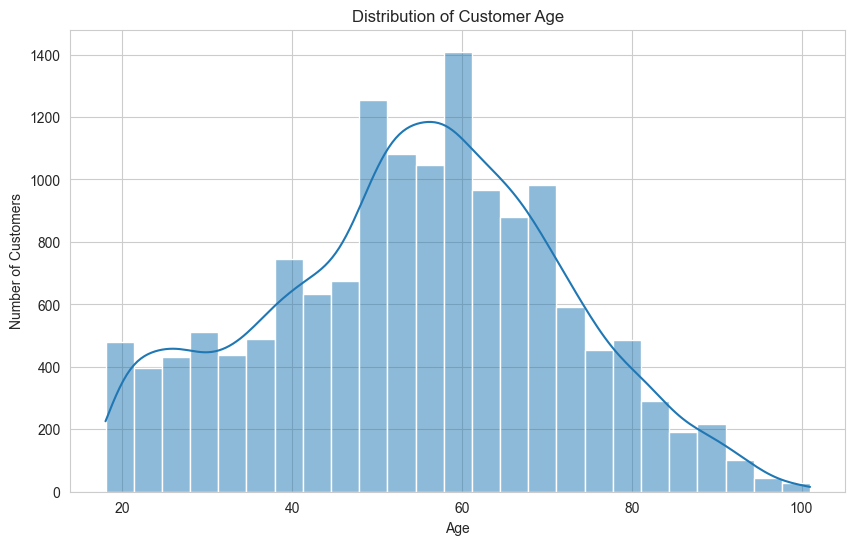

In [11]:
#Age Distribution: To see the shape of the customer base
plt.figure(figsize=(10, 6))
sns.histplot(data=customers_cleaned, x='age', bins=25, kde=True)
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

**Comment**
Peak Age Range: Around 55-60 years old
KDE Curve: Shows the peak is around age 55-58
Core demographic is older adults-senior (50-65)
Marketing strategies should likely target this age group
Consider products/services that appeal to this demographic
Younger customer acquisition (under 40) might be an opportunity for growth

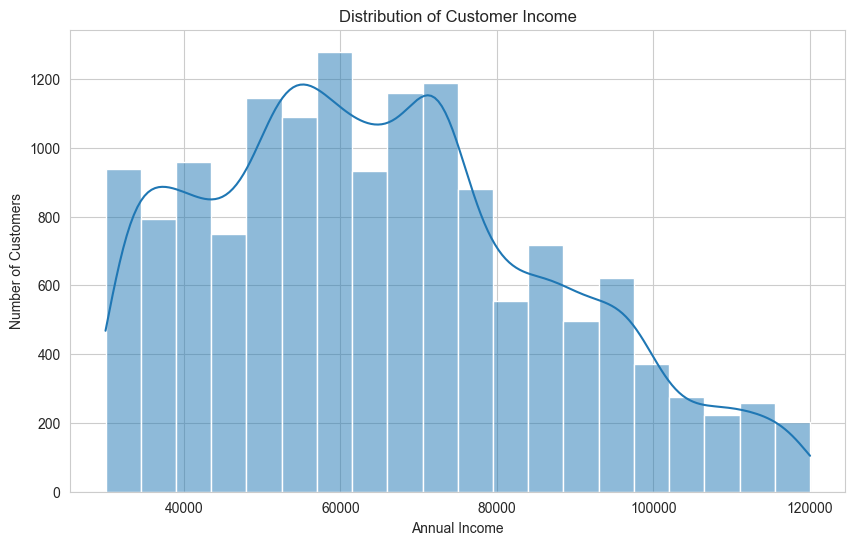

In [12]:
#Income Distribution:
plt.figure(figsize=(10, 6))
sns.histplot(data=customers_cleaned, x='income', bins=20, kde=True)
plt.title('Distribution of Customer Income')
plt.xlabel('Annual Income')
plt.ylabel('Number of Customers')
plt.show()

**Comment**
The majority of customers are middle-income earners ($50k–$80k).
The customer income distribution is moderately right-skewed, indicating fewer high-income customers.
Targeting promotions or offers toward the middle-income group could yield the highest engagement

(306137, 6)


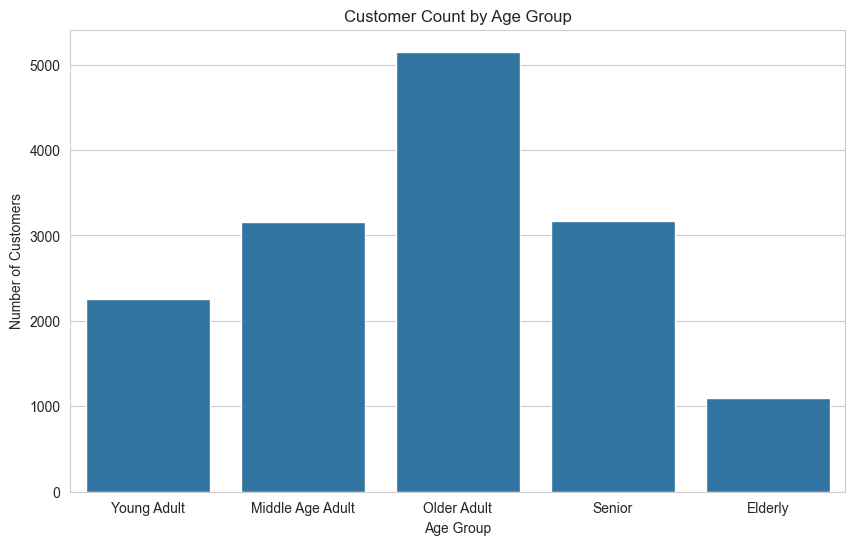

In [13]:
#Age Group Counts: To show the size of your cohorts.
plt.figure(figsize=(10, 6))
sns.countplot(data=customers_cleaned, x='age_group', order=age_labels)
plt.title('Customer Count by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Customers')
plt.show()

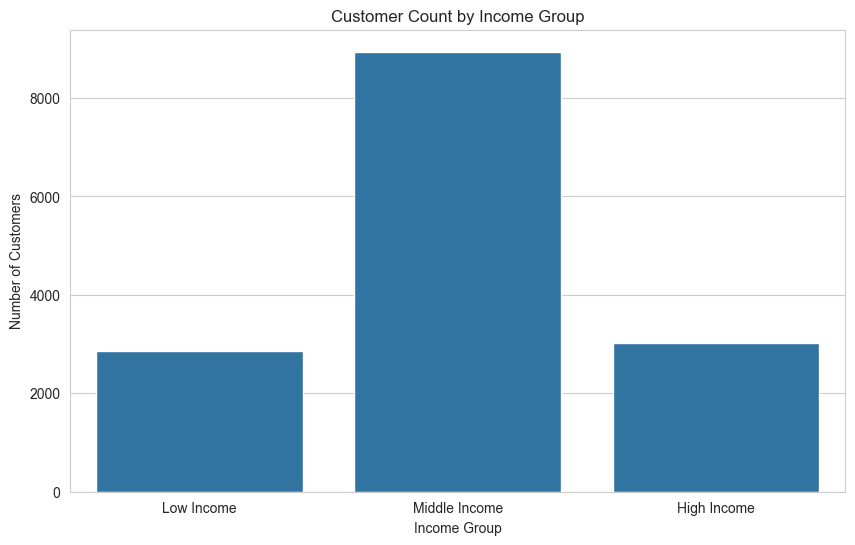

In [14]:
#Income Group Counts
plt.figure(figsize=(10, 6))
sns.countplot(data=customers_cleaned, x='income_group', order=income_labels)
plt.title('Customer Count by Income Group')
plt.xlabel('Income Group')
plt.ylabel('Number of Customers')
plt.show()

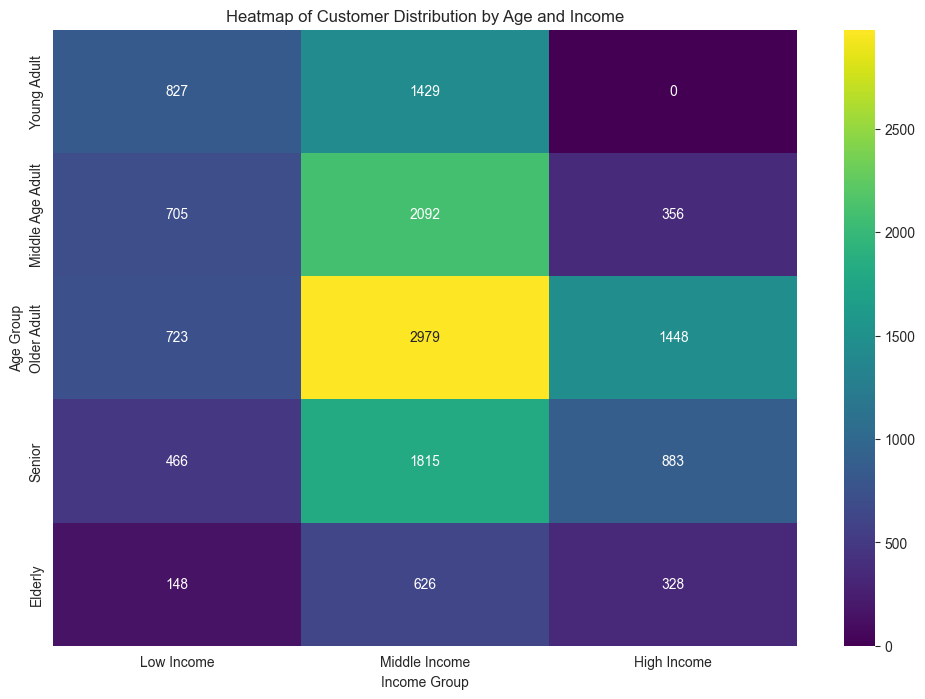

In [15]:
#create a heatmap to show where the "heart" of our customer base is.
# We use pd.crosstab() to create a 2D matrix of customer counts.

age_income_crosstab = pd.crosstab(
    customers_cleaned['age_group'],
    customers_cleaned['income_group']
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    age_income_crosstab,
    annot=True,     # Show the numbers in each cell
    fmt='d',        # Format as integers (e.g., "5,000" not "5.0e+3")
    cmap='viridis'  # A common, clear color map
)
plt.title('Heatmap of Customer Distribution by Age and Income')
plt.ylabel('Age Group')
plt.xlabel('Income Group')
plt.show()

**Comment**
Hottest Spots (Largest Customer Segments): Older Adult + Middle Income = 2,979 customers

### 2.3: Preprocess `df_event` & Merge

The `df_event` data is clean, but it's the link between customers and offers. Next step is to create one master DataFrame that contains all information for every event.

Informational offers do **not** have an 'offer completed' event. A customer "completes" one by viewing it and then making any transaction within its duration.

In [16]:
# Create a copy for preprocessing
events_cleaned = df_event.copy()

### Merge all 3 cleaned dataframes into one master table
 This brings customer demographics and offer details into one timeline.

In [17]:
#check events_clened before final merge
print(events_cleaned.shape)
events_cleaned.head()

(306137, 6)


,customer_id,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [18]:
#check customer_cleaned before final merge
print(customers_cleaned.shape)
customers_cleaned.head()

(14825, 8)


,customer_id,became_member_on,gender,age,income,membership_year,age_group,income_group
0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0,2017,Older Adult,High Income
1,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0,2017,Senior,High Income
2,e2127556f4f64592b11af22de27a7932,2018-04-26,M,68,70000.0,2018,Senior,Middle Income
3,389bc3fa690240e798340f5a15918d5c,2018-02-09,M,65,53000.0,2018,Senior,Middle Income
4,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,M,58,51000.0,2017,Older Adult,Middle Income


In [19]:
###  Merging Master Data
# I will use the 'events_cleaned' as the LEFT table.
# This ensures we keep all 306,137 events.
# Events from customers not in 'customers_cleaned' will have NaN

df_master = pd.merge(events_cleaned, customers_cleaned, on='customer_id', how='left')

print(f"Total rows in events log: {len(events_cleaned)}")
print(f"Total rows after merge:   {len(df_master)}")
print("-" * 30)

# Now, must check for the orphan events
orphan_events = df_master['age_group'].isnull().sum()
print(f"Found {orphan_events} 'orphan' events with no matching customer.")

Total rows in events log: 306137
Total rows after merge:   306137
------------------------------
Found 33749 'orphan' events with no matching customer.


In [20]:
### Dropping Orphan Data
# I cannot analyze events if we don't know the customer's demographics.
# Therefore,it will best to drop these 33,749 rows.

rows_before_drop = df_master.shape[0]
df_master = df_master.dropna(subset=['age_group', 'income_group', 'gender'])
rows_after_drop = df_master.shape[0]

print(f"Dropped {rows_before_drop - rows_after_drop} orphan event rows.")
print(f"New master DataFrame shape: {df_master.shape}")


Dropped 33749 orphan event rows.
New master DataFrame shape: (272388, 13)


In [21]:
# Now, need to merge the offer data.
# I use 'left' because transaction events won't have an offer_id.
df_master = pd.merge(df_master, offers_cleaned, on='offer_id', how='left')
df_master.head()

,customer_id,event,time,offer_id,amount,reward_x,became_member_on,gender,age,income,membership_year,age_group,income_group,offer_type,difficulty,reward_y,duration,channels,duration_hours,offer_key
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",168.0,bogo-5-5-7
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,discount,10.0,2.0,7.0,"['web', 'email', 'mobile']",168.0,discount-10-2-7
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,2018-02-09,M,65.0,53000.0,2018.0,Senior,Middle Income,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",120.0,bogo-5-5-5
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2017-11-11,M,58.0,51000.0,2017.0,Older Adult,Middle Income,informational,0.0,0.0,4.0,"['web', 'email', 'mobile']",96.0,informational-0-0-4
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,2017-09-11,F,61.0,57000.0,2017.0,Older Adult,Middle Income,discount,20.0,5.0,10.0,"['web', 'email']",240.0,discount-20-5-10


In [22]:
# Sort chronologically for each customer. This is crucial for the iteration logic.
df_master = df_master.sort_values(['customer_id', 'time'])

print(f"Final, cleaned master DataFrame shape: {df_master.shape}")
df_master.head()

Final, cleaned master DataFrame shape: (272388, 20)


,customer_id,event,time,offer_id,amount,reward_x,became_member_on,gender,age,income,membership_year,age_group,income_group,offer_type,difficulty,reward_y,duration,channels,duration_hours,offer_key
49809,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,3.0,"['email', 'mobile', 'social']",72.0,informational-0-0-3
68952,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,3.0,"['email', 'mobile', 'social']",72.0,informational-0-0-3
79386,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101111,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,4.0,"['web', 'email', 'mobile']",96.0,informational-0-0-4
124364,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,4.0,"['web', 'email', 'mobile']",96.0,informational-0-0-4


In [23]:
##check total number of duplicated rows
df_master.duplicated().sum() 

np.int64(0)

In [24]:
#check amount of different offers
df_master.event.value_counts()

event
transaction        123957
offer received      66501
offer viewed        49860
offer completed     32070
Name: count, dtype: int64

In [25]:
# lets check data for some customers to understand the data 
df_master[df_master.customer_id=="0009655768c64bdeb2e877511632db8f"]

,customer_id,event,time,offer_id,amount,reward_x,became_member_on,gender,age,income,membership_year,age_group,income_group,offer_type,difficulty,reward_y,duration,channels,duration_hours,offer_key
49809,0009655768c64bdeb2e877511632db8f,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,3.0,"['email', 'mobile', 'social']",72.0,informational-0-0-3
68952,0009655768c64bdeb2e877511632db8f,offer viewed,192,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,3.0,"['email', 'mobile', 'social']",72.0,informational-0-0-3
79386,0009655768c64bdeb2e877511632db8f,transaction,228,NaN,22.16,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101111,0009655768c64bdeb2e877511632db8f,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,4.0,"['web', 'email', 'mobile']",96.0,informational-0-0-4
124364,0009655768c64bdeb2e877511632db8f,offer viewed,372,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,informational,0.0,0.0,4.0,"['web', 'email', 'mobile']",96.0,informational-0-0-4
136355,0009655768c64bdeb2e877511632db8f,offer received,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",120.0,bogo-5-5-5
149503,0009655768c64bdeb2e877511632db8f,transaction,414,NaN,8.57,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149504,0009655768c64bdeb2e877511632db8f,offer completed,414,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",120.0,bogo-5-5-5
166644,0009655768c64bdeb2e877511632db8f,offer viewed,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,bogo,5.0,5.0,5.0,"['web', 'email', 'mobile', 'social']",120.0,bogo-5-5-5
181620,0009655768c64bdeb2e877511632db8f,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2017-04-21,M,33.0,72000.0,2017.0,Young Adult,Middle Income,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",240.0,discount-10-2-10


In [26]:
# lets check data for some customers to understand the data 
df_master[df_master.customer_id=="78afa995795e4d85b5d9ceeca43f5fef"]

,customer_id,event,time,offer_id,amount,reward_x,became_member_on,gender,age,income,membership_year,age_group,income_group,offer_type,difficulty,reward_y,duration,channels,duration_hours,offer_key
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",168.0,bogo-5-5-7
13545,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",168.0,bogo-5-5-7
42328,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42329,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",168.0,bogo-5-5-7
44065,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47385,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,informational,0.0,0.0,3.0,"['email', 'mobile', 'social']",72.0,informational-0-0-3
75792,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,informational,0.0,0.0,3.0,"['email', 'mobile', 'social']",72.0,informational-0-0-3
77440,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,NaN,19.67,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81925,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,NaN,29.72,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125790,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,NaN,23.93,NaN,2017-05-09,F,75.0,100000.0,2017.0,Senior,High Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# lets check data for some customers to understand the data 
df_master[df_master.customer_id=="e2127556f4f64592b11af22de27a7932"]

,customer_id,event,time,offer_id,amount,reward_x,became_member_on,gender,age,income,membership_year,age_group,income_group,offer_type,difficulty,reward_y,duration,channels,duration_hours,offer_key
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,discount,10.0,2.0,7.0,"['web', 'email', 'mobile']",168.0,discount-10-2-7
17760,e2127556f4f64592b11af22de27a7932,offer viewed,18,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,discount,10.0,2.0,7.0,"['web', 'email', 'mobile']",168.0,discount-10-2-7
91389,e2127556f4f64592b11af22de27a7932,transaction,288,NaN,17.88,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92467,e2127556f4f64592b11af22de27a7932,transaction,294,NaN,21.43,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98704,e2127556f4f64592b11af22de27a7932,offer received,336,3f207df678b143eea3cee63160fa8bed,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,informational,0.0,0.0,4.0,"['web', 'email', 'mobile']",96.0,informational-0-0-4
133940,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",168.0,bogo-5-5-7
151980,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,bogo,5.0,5.0,7.0,"['web', 'email', 'mobile']",168.0,bogo-5-5-7
179226,e2127556f4f64592b11af22de27a7932,offer received,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",240.0,discount-10-2-10
199771,e2127556f4f64592b11af22de27a7932,offer viewed,522,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,discount,10.0,2.0,10.0,"['web', 'email', 'mobile', 'social']",240.0,discount-10-2-10
199772,e2127556f4f64592b11af22de27a7932,transaction,522,NaN,18.42,NaN,2018-04-26,M,68.0,70000.0,2018.0,Senior,Middle Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### What I got?
1. `transaction` may happen without `offer_completed`.We can not attribute them as offer_related_transaction as the rule is **For a transaction to be attributed to an offer, it must occur at the same time as when the offer was "completed" by the customer**.
2. In some cases offers are received, viewed but not completed.
3. In some cases offers are received, completed but not viewed.I will also not include this as offer related transaction.Because it could be a coincidence, not a offer prompted transaction.
4. A customer recevied multiple offers without viewing the previous offer.
5. A customer complete two offers with one transaction. I need to check, how one transaction will assoicate with two offers.

So, a transaction will be attributed to offer if it follows the hierarchy. offer_received --> offer_viewed --> offer_completed & Transaction happened together. Otherwise, the events will not be in the final dataset. This will define **truly influenced purchase**.


## Part 3: Building the Offer Attribution Funnel

This is the most critical step. The dataset does not explicitly link transactions to offers, so we must build this link logically.

**My Logic for a "Successful Offer":**
A successful, attributed offer must follow this exact sequence:
1.  **Offer Received:** The `offer received` event starts the clock.
2.  **Offer Viewed:** The customer must view the offer *after* receiving it and *before* it expires.
3.  **Offer Completed:** The customer must complete the offer *after* viewing it and *before* it expires.
4.  **Transaction Match:** A `transaction` event must exist at the *exact same time* as the `offer completed` event.

### 3.1: Building the Attribution Function

This function will process the event history for a *single customer* and return a list of all their successful offer journeys.

**Note on Informational Offers:**
Informational offers have no 'offer completed' event. Their goal is just to drive a transaction. For now, I will focus **only on BOGO and Discount offers** (which have 'offer completed' events). I will explicitly skip informational offers for now.

In [28]:
### 3.1: Building the attribution function
def process_customer_events(events):

    """
    This function processes events from a DataFrame for a single customer to identify valid, completed offers.

    It will take dataset and return a list of dictionaries

    """

    successful_journey= []

    # --- Keep track of completion events that is already used ---
    used_completion_indices = set()

    #get all transaction for quick lookup. later we will need it to connect offer_completion
    df_transaction=events[events.event=="transaction"]

    #start with offer_received event
    received_offers=events[events.event=="offer received"]

    for _,offer in received_offers.iterrows():

        #skip informational offers
        if offer["offer_type"] not in ["bogo","discount"]:
            continue

        #calculate when offer expires
        offer_start=offer["time"]
        offer_expires=offer_start+offer["duration_hours"]
        offer_id=offer["offer_id"]

        #--Did they view the offer?---
        viewed=events[
            (events.event=="offer viewed") &
            (events.offer_id==offer_id) &
            (events.time>=offer_start) &
            (events.time<=offer_expires)
        ]

        first_view=viewed.head(1)

        if first_view.empty:
            continue #offer never viewed ->skip

        view_time = first_view['time'].iloc[0] #use first view


        #---Did they complete the offer?--

        completed=events[
            (events.event=="offer completed") &
            (events.offer_id==offer_id) &
            (events.time>=view_time) &
            (events.time<=offer_expires)
        ]

        first_completion = completed.head(1)

        if first_completion.empty:
            continue

        completion_time=first_completion['time'].iloc[0]

        # --- Check if this completion has already been used ---
        completion_index = first_completion.index[0]
        if completion_index in used_completion_indices:
            continue # This completion was already attributed, skip this funnel

        # ---was thery a transaction at completion?---
        transaction=df_transaction[df_transaction.time==completion_time]

        if transaction.empty:
            continue #no transaction -> skip

        #----save this journey---

        journey={
            "customer_id":offer["customer_id"],
            "offer_id":offer_id,
            "offer_key":offer["offer_key"],
            "offer_type":offer["offer_type"],
            "channels":offer["channels"],

            #customer demographics
            "age_group":offer["age_group"],
            "gender":offer["gender"],
            "income_group":offer["income_group"],
            "membership_year":offer["membership_year"],

            #joureny timeline
            "time_rcvd": offer_start,
            "time_viewed": view_time,
            "time_completed": completion_time,

            #financial data
            "transaction_amount":transaction.iloc[0]["amount"],
            "reward": first_completion.iloc[0]["reward_x"]
        }

        successful_journey.append(journey)

        # ---Mark this completion as "used" ---
        used_completion_indices.add(completion_index)


    return successful_journey
            
    
    

### 3.2: Applying the Function and Creating the Final DataFrame

Now i will apply this function to every customer. We use `.groupby('customer_id')` and `.apply()` to run our function on each customer's event-block. This will take a moment.

In [29]:
### 3.2: Applying the Function and Creating the Final DataFrame

print("Processing customer events... This may take a minute.")

# Group the master table by customer_id and apply our function
all_journeys = df_master.groupby('customer_id').apply(process_customer_events)

# must flatten the above list.
final_data = [item for sublist in all_journeys for item in sublist]

# Create our final, clean DataFrame
df_final = pd.DataFrame(final_data)

print(f"Process complete.")
print(f"Created final DataFrame with {df_final.shape[0]} successfully attributed BOGO/Discount completions.")
df_final.head()

Processing customer events... This may take a minute.
Process complete.
Created final DataFrame with 22533 successfully attributed BOGO/Discount completions.


,customer_id,offer_id,offer_key,offer_type,channels,age_group,gender,income_group,membership_year,time_rcvd,time_viewed,time_completed,transaction_amount,reward
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount-7-3-7,discount,"['web', 'email', 'mobile', 'social']",Middle Age Adult,O,Middle Income,2018.0,168,186,252,11.93,3.0
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount-20-5-10,discount,"['web', 'email']",Middle Age Adult,O,Middle Income,2018.0,408,432,576,22.05,5.0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5-5-7,bogo,"['web', 'email', 'mobile']",Middle Age Adult,O,Middle Income,2018.0,504,516,576,22.05,5.0
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,discount-10-2-10,discount,"['web', 'email', 'mobile', 'social']",Older Adult,F,High Income,2016.0,0,12,54,17.63,2.0
4,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo-10-10-5,bogo,"['web', 'email', 'mobile', 'social']",Older Adult,F,High Income,2016.0,408,426,510,17.24,10.0


### 3.3. Check and verify the data whether sequence are okay or not

In [30]:
#Check is there any row where rcv_time<view_time is not followed
df_final[df_final.time_rcvd>df_final.time_viewed]	

,customer_id,offer_id,offer_key,offer_type,channels,age_group,gender,income_group,membership_year,time_rcvd,time_viewed,time_completed,transaction_amount,reward


In [31]:
#Check is there any row where view_time<completed_time is not followed
df_final[df_final.time_viewed>df_final.time_completed]	

,customer_id,offer_id,offer_key,offer_type,channels,age_group,gender,income_group,membership_year,time_rcvd,time_viewed,time_completed,transaction_amount,reward


In [32]:
#check some data for previous customers
df_final[df_final.customer_id=="0009655768c64bdeb2e877511632db8f"]

,customer_id,offer_id,offer_key,offer_type,channels,age_group,gender,income_group,membership_year,time_rcvd,time_viewed,time_completed,transaction_amount,reward


In [33]:
#check some data for previous customers
df_final[df_final.customer_id=="e2127556f4f64592b11af22de27a7932"]

,customer_id,offer_id,offer_key,offer_type,channels,age_group,gender,income_group,membership_year,time_rcvd,time_viewed,time_completed,transaction_amount,reward
19879,e2127556f4f64592b11af22de27a7932,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo-5-5-7,bogo,"['web', 'email', 'mobile']",Senior,M,Middle Income,2018.0,408,420,522,18.42,5.0
19880,e2127556f4f64592b11af22de27a7932,fafdcd668e3743c1bb461111dcafc2a4,discount-10-2-10,discount,"['web', 'email', 'mobile', 'social']",Senior,M,Middle Income,2018.0,504,522,522,18.42,2.0


For this customer one `transaction` happened for two `offer_completion` that I saw previously. However, here one transaction got linked to two rows. It means that as `transaction` didn't have any offer_id, it will create problems to link transaction with an specific offer, which evantually will not help to get actual revenue. 
I will keep this data's as they show me the potential of this offer.

### 3.4: Inspect the Final Analysis-Ready Data

Finally, i got 22533 offer related rows. I will move further with this data.
Let's do a quick check on our new, clean DataFrame.

In [34]:
# Check for any duplicates. This should be 0.
print(f"Duplicate rows: {df_final.duplicated().sum()}")

# Check for nulls. This should be 0.
print(f"Null values:\\n{df_final.isnull().sum()}")

# Look at the descriptive data
df_final.describe()

Duplicate rows: 0
Null values:\ncustomer_id           0
offer_id              0
offer_key             0
offer_type            0
channels              0
age_group             0
gender                0
income_group          0
membership_year       0
time_rcvd             0
time_viewed           0
time_completed        0
transaction_amount    0
reward                0
dtype: int64


,membership_year,time_rcvd,time_viewed,time_completed,transaction_amount,reward
count,22533.000000,22533.000000,22533.00000,22533.000000,22533.000000,22533.000000
mean,2016.409089,326.194648,345.37079,390.040474,20.464685,4.965118
std,1.146143,194.858809,194.80457,196.567161,40.897619,3.029037
min,2013.000000,0.000000,0.00000,0.000000,0.150000,2.000000
25%,2016.000000,168.000000,180.00000,222.000000,11.230000,2.000000
50%,2017.000000,336.000000,384.00000,426.000000,16.660000,5.000000
75%,2017.000000,504.000000,510.00000,552.000000,23.110000,5.000000
max,2018.000000,576.000000,708.00000,714.000000,1015.730000,10.000000


**Comment:**
Average offer_related_transaction amount is $20.46. 
And, average reward amount is $4.95. 

## Part 4: Analysis

With this clean `df_final` DataFrame, I can now confidently analyze offer effectiveness and customer behavior.

This analysis will answer four key questions:
1.  **Financial Impact:** What is the real financial impact of these offers?
2.  **Offer Performance:** Which specific offers are the most effective at driving completions?
3.  **Customer Performance:** Which demographic segments (age, income, gender) are most responsive to offers?

### 4.1: Financial Impact Analysis

### 4.1.1.: 
I will calculate the total revenue generated *directly* from our attributed offers and compare it to the total cost (rewards paid out). This gives us a clear reward-to-sales ratio.

In [35]:
# --- Calculate Revenue and Costs ---

# Total revenue from successfully completed BOGO/Discount offers
total_offer_revenue = df_final['transaction_amount'].sum()

# Total cost of rewards for these offers
total_offer_reward = df_final['reward'].sum()

# Reward-to-Sales Ratio
# This tells us what percentage of the offer_driven revenue
# is given back to the customer as a reward.
reward_to_sale_ratio = (total_offer_reward / total_offer_revenue) * 100

print(f"--- Offer Financials (BOGO/Discount) ---")
print(f"Total Attributed Revenue: ${total_offer_revenue:,.2f}")
print(f"Total Rewards Paid:       ${total_offer_reward:,.2f}")
print(f"Reward-to-Sales Ratio:    {reward_to_sale_ratio:.2f}%")
print(f"\nThis means for every $1.00 in sales generated by an offer, we spent ${reward_to_sale_ratio/100:.2f} on the reward.")

--- Offer Financials (BOGO/Discount) ---
Total Attributed Revenue: $461,130.75
Total Rewards Paid:       $111,879.00
Reward-to-Sales Ratio:    24.26%

This means for every $1.00 in sales generated by an offer, we spent $0.24 on the reward.


#### 4.1.2.:
I want to compare the total revenue with or without offer. 
From df_transaction, I will get total transaction amount.
After that i can have the ratio between offer_related_reveue and total revenue

In [36]:
#how many transactions happened overall?
df_transaction=df_master[df_master.event=="transaction"]
print(f"The number of total transaction is {df_transaction.shape[0]}")
#get total revenue
total_transaction_amount=df_transaction.amount.sum()
print(f"Total Revenue is ${total_transaction_amount:.2f}")
#overall average revenue with or without offer
print(f"Average revenue with or without offer is: ${total_transaction_amount/(df_transaction.shape[0]):.2f}")
#how much percentage of total revenue is offer related?
print(f"{total_offer_revenue/total_transaction_amount*100:.2f} percent of total revenue is offer related")

The number of total transaction is 123957
Total Revenue is $1734942.40
Average revenue with or without offer is: $14.00
26.58 percent of total revenue is offer related


### 4.1.3:
Which one is successfull? with or without offer?
I can have this idea by calculating mean transaction amount.
For this case, I need to seperate offer related transaction and non-offer related transaction

In [37]:
#1. I must set a unique index (customer + time) for df_transaction
df_transaction = df_transaction.set_index(['customer_id', 'time'])
#2. I must set a unique index (customer + time) for df_final
df_final_transaction = df_final.set_index(['customer_id', 'time_completed'])
#3. Create a boolean mask
# .isin() checks if an index from 'df_transaction' also exists
# in 'df_final_transaction'.
is_offer_driven_mask = df_transaction.index.isin(df_final_transaction.index)
# 4. Separate and compare
offer_txns = df_transaction[is_offer_driven_mask]
non_offer_txns = df_transaction[~is_offer_driven_mask]
print(f"Total offer related transaction is {offer_txns.shape}")
print(f"Total non offer transaction is {non_offer_txns.shape}")
# 5. Calculate averages
avg_offer_txn = offer_txns['amount'].mean()
avg_non_offer_txn = non_offer_txns['amount'].mean()

print(f"Average Offer-Driven Transaction: ${avg_offer_txn:,.2f}")
print(f"Average Non-Offer Transaction:    ${avg_non_offer_txn:,.2f}")
print(f"\nInsight: Offer-driven purchases are, on average, {((avg_offer_txn/avg_non_offer_txn) - 1):.1%} more valuable.")

Total offer related transaction is (21642, 18)
Total non offer transaction is (102315, 18)
Average Offer-Driven Transaction: $20.19
Average Non-Offer Transaction:    $12.69

Insight: Offer-driven purchases are, on average, 59.2% more valuable.


**Comment**
Here I got 21642 offer related transaction, instead of 22533. It is because one transaction got attached to multiple offer_completion in some cases.

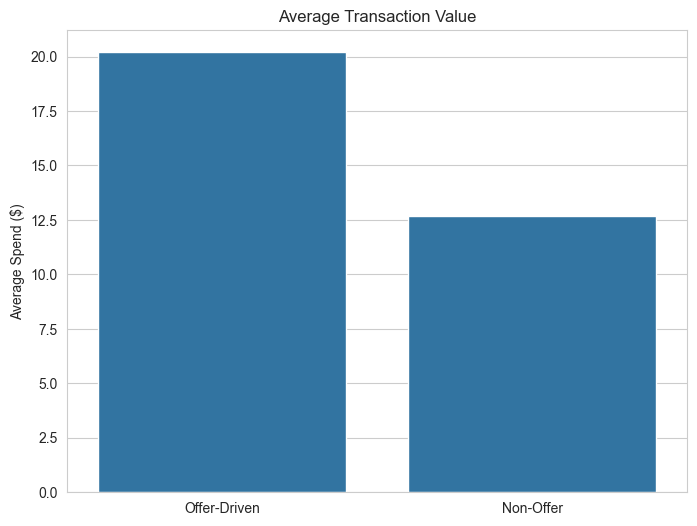

In [38]:
# Create a simple DataFrame for plotting
df_plot_avg = pd.DataFrame({
    'Transaction Type': ['Offer-Driven', 'Non-Offer'],
    'Average Spend': [avg_offer_txn, avg_non_offer_txn]
})

plt.figure(figsize=(8, 6))
sns.barplot(data=df_plot_avg, x='Transaction Type', y='Average Spend')
plt.title('Average Transaction Value')
plt.ylabel('Average Spend ($)')
plt.xlabel('')
plt.show()

### 4.2: Offer Performance (Conversion Rate)

I need to know how the offer performs. How many percentage of received offers are actually viewed. And How many viewed offers are actually completed.
This will also help me to check the funnel leakage.

### 4.2.1.: In order to this. I must get df_received based on customers who receive bogo and discount offers. 

In [39]:
# get df_offer_received without including the informational offers
df_offer_received = df_master[
    (df_master['event'] == 'offer received') &
    (df_master['offer_type'].isin(['bogo', 'discount']))
]
print(df_offer_received.shape[0])

53201


### 4.2.2.: now we need to get offer viewed counts by iterating the received events
i will create a function to get offer viewed events
As one customer may view multiple received offers, this function will help to get actual viewed events from received events. that will follow following condition viewed_events<=received_events+duration
I will count the first viewed events for a specific received offer

In [40]:

def get_viewed_events(events):

    #ar first creat an empty list to get all the viewed events
    successful_views_list=[]

    #get total_received and total_viewed events
    total_viewed_events=events[events.event=="offer viewed"]
    total_received_events=events[events.event=="offer received"]

    #iterate through total_received events
    for _,offer in total_received_events.iterrows():

        #skip informational offers

        if offer["offer_type"] not in ["bogo","discount"]:
            continue

        #get offer_id, start_time, expire_time
        offer_id=offer["offer_id"]
        offer_start=offer["time"]
        offer_expire=offer_start+offer["duration_hours"]

        #create a view mask
        view_mask=(
            (total_viewed_events["offer_id"]==offer_id) &
            (total_viewed_events["time"]>=offer_start) &
            (total_viewed_events["time"]<=offer_expire)
        )

        #get the first_view
        first_view=total_viewed_events[view_mask].head(1)

        if not first_view.empty:
            #create the successful journey
            journey={
                "customer_id":offer["customer_id"],
                "offer_key":offer["offer_key"],
                "offer_type":offer["offer_type"],
                "rcvd_time":offer["time"],
                "viewed_time":first_view["time"].iloc[0],
                "trnx_amount":offer["amount"],
                "reward":offer["reward_x"],
                "gender":offer["gender"],
                "age":offer["age"],
                "income":offer["income"],
                "membership_year":offer["membership_year"],
                "age_group":offer["age_group"],
                "income_group":offer["income_group"],
                "duration":offer["duration_hours"],
                "channels":offer["channels"]}

            successful_views_list.append(journey)

    return successful_views_list
            
# --- Apply the function and build the new DataFrame ---
print("Processing viewed_events... (This may take a minute)")
viewed_events_journey = df_master.groupby('customer_id').apply(get_viewed_events)
viewed_events = [item for sublist in viewed_events_journey for item in sublist]
df_offer_viewed = pd.DataFrame(viewed_events)

print(f"Offer Based Viewed Events Found: {df_offer_viewed.shape[0]}")
df_offer_viewed.head()

Processing viewed_events... (This may take a minute)
Offer Based Viewed Events Found: 40524


,customer_id,offer_key,offer_type,rcvd_time,viewed_time,trnx_amount,reward,gender,age,income,membership_year,age_group,income_group,duration,channels
0,0009655768c64bdeb2e877511632db8f,bogo-5-5-5,bogo,408,456,NaN,NaN,M,33.0,72000.0,2017.0,Young Adult,Middle Income,120.0,"['web', 'email', 'mobile', 'social']"
1,0009655768c64bdeb2e877511632db8f,discount-10-2-10,discount,504,540,NaN,NaN,M,33.0,72000.0,2017.0,Young Adult,Middle Income,240.0,"['web', 'email', 'mobile', 'social']"
2,0011e0d4e6b944f998e987f904e8c1e5,discount-7-3-7,discount,168,186,NaN,NaN,O,40.0,57000.0,2018.0,Middle Age Adult,Middle Income,168.0,"['web', 'email', 'mobile', 'social']"
3,0011e0d4e6b944f998e987f904e8c1e5,discount-20-5-10,discount,408,432,NaN,NaN,O,40.0,57000.0,2018.0,Middle Age Adult,Middle Income,240.0,"['web', 'email']"
4,0011e0d4e6b944f998e987f904e8c1e5,bogo-5-5-7,bogo,504,516,NaN,NaN,O,40.0,57000.0,2018.0,Middle Age Adult,Middle Income,168.0,"['web', 'email', 'mobile']"


### 4.2.3.: Calculate the converstion rate from R to V to C
I already got df_offer_received, df_offer_viewed, form df_final i can get total offer completion

In [41]:
# Get the total counts for each stage
total_received = df_offer_received.shape[0]
total_viewed = df_offer_viewed.shape[0]
total_completed = df_final.shape[0]

# --- Build the Funnel DataFrame ---
funnel_data = {
    'Stage': ['1. Received', '2. Viewed', '3. Completed'],
    'Count': [total_received, total_viewed, total_completed]
}
df_funnel = pd.DataFrame(funnel_data)

# Calculate drop-off
df_funnel['Conversion (from Received)'] = (df_funnel['Count'] / total_received * 100).round(2).astype(str) + '%'
df_funnel['Conversion (from Previous Step)'] = ''
df_funnel.loc[0, 'Conversion (from Previous Step)'] = '100.00%'
df_funnel.loc[1, 'Conversion (from Previous Step)'] = f"{(total_viewed / total_received * 100):.2f}%"
df_funnel.loc[2, 'Conversion (from Previous Step)'] = f"{(total_completed / total_viewed * 100):.2f}%"


print("\n--- Funnel Leakage Report ---")
df_funnel


--- Funnel Leakage Report ---


,Stage,Count,Conversion (from Received),Conversion (from Previous Step)
0,1. Received,53201,100.0%,100.00%
1,2. Viewed,40524,76.17%,76.17%
2,3. Completed,22533,42.35%,55.60%


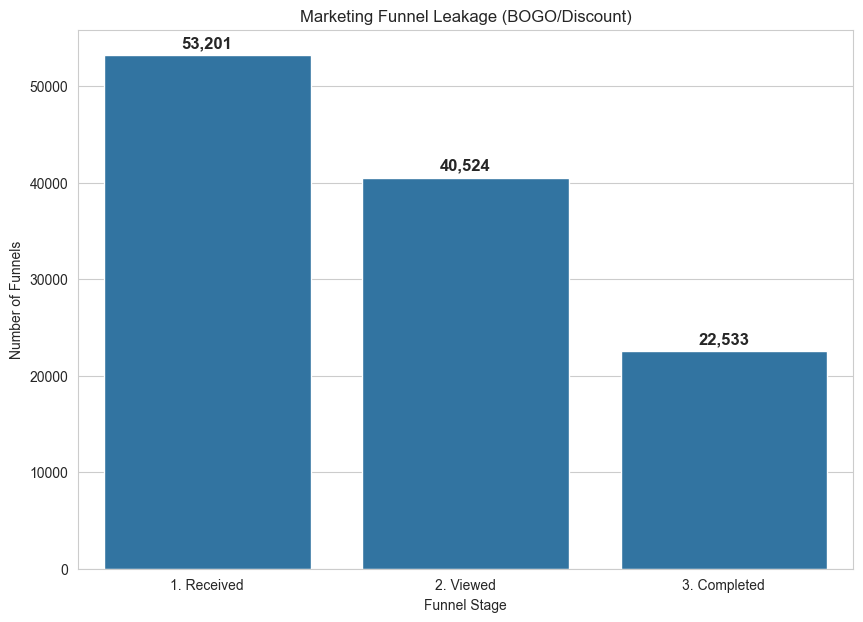

In [42]:
# --- Visualize the Funnel ---
plt.figure(figsize=(10, 7))
sns.barplot(data=df_funnel, x='Stage', y='Count')
plt.title('Marketing Funnel Leakage (BOGO/Discount)')
plt.ylabel('Number of Funnels')
plt.xlabel('Funnel Stage')

# Add annotations
for index, row in df_funnel.iterrows():
    plt.text(index, row['Count'] + 500, f"{row['Count']:,}", 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

**Comment:**

53,201 offers were sent out.

Only 40,524 were ever viewed.

This means 23.83% of our offers (100% - 76.17%) failed because the customer never even saw them.

again,

40,524 customers saw an offer.

Only 22,533 of them acted on it.

This means (100% - 55.60%)= 44.40% of aware customers looked at the deal and did not pay any interest.

This data strongly supports my finding from Cell 41: push to get customers onto all four channels (['web', 'email', 'mobile', 'social']) to maximize the chance they actually see the offer sent.

### 4.2.3.: Calculate the offer type performance

In [43]:
# 1. Get completion counts from df_final
completed = df_final['offer_key'].value_counts()
# 2. Get received counts from the df_offer_received
received = df_offer_received['offer_key'].value_counts()
#3. Get viewed counts from the df_offer_viewed
viewed = df_offer_viewed['offer_key'].value_counts()


# 4. Create the new df_offer_performance DataFrame
df_offer_performance = pd.DataFrame({
    "received":received,
    'Viewed': viewed,
    'Completed': completed
})

# 4. Calculate the true r->v, v->c, and r->c rate
df_offer_performance['R_to_V_Rate (%)'] = (df_offer_performance['Viewed'] / df_offer_performance['received']) * 100
df_offer_performance['V_to_C_Rate (%)'] = (df_offer_performance['Completed'] / df_offer_performance['Viewed']) * 100
df_offer_performance['R_to_C_Rate (%)'] = (df_offer_performance['Completed'] / df_offer_performance['received']) * 100

df_offer_performance=df_offer_performance.sort_values(by=["R_to_C_Rate (%)"],inplace=False,ascending=False)

print("\n--- Offer performance ---")
print(df_offer_performance.to_string(formatters={
    'V_to_C_Rate (%)': '{:,.2f}%'.format,
    'R_to_V_Rate (%)': '{:,.2f}%'.format,
    'R_to_C_Rate (%)': '{:,.2f}%'.format,
}))


--- Offer performance ---
                  received  Viewed  Completed R_to_V_Rate (%) V_to_C_Rate (%) R_to_C_Rate (%)
offer_key                                                                                    
discount-10-2-10      6652    6433       4329          96.71%          67.29%          65.08%
discount-7-3-7        6655    6390       4119          96.02%          64.46%          61.89%
bogo-5-5-5            6576    6279       3374          95.48%          53.73%          51.31%
bogo-10-10-5          6593    6282       2731          95.28%          43.47%          41.42%
bogo-10-10-7          6683    5901       2585          88.30%          43.81%          38.68%
discount-10-2-7       6631    3457       2047          52.13%          59.21%          30.87%
bogo-5-5-7            6685    3507       2037          52.46%          58.08%          30.47%
discount-20-5-10      6726    2275       1311          33.82%          57.63%          19.49%


**Comment**

This table separates an offer's Discovery (R->V) from its Persuasion (V->C).

discount-20-5-10 (33.82%) is a total failure in terms of channels. Two-thirds of the people never even saw it.

The bogo-10-10... offers are terrible. Even when people saw them, 56-57% of them did not respond." The $10 difficulty is too high for a BOGO.

The Perfect Offer: discount-10-2-10 and discount-7-3-7 are your superstars. They were sent on good channels (high R->V) and had a persuasive message (high V->C).

discount-10-2-7 had a great persuasion rate (59.21%), but it was may be put on terrible channels (52.13% R->V), so it failed. This wasn't a bad offer; may be it was a marketing-channel failure.

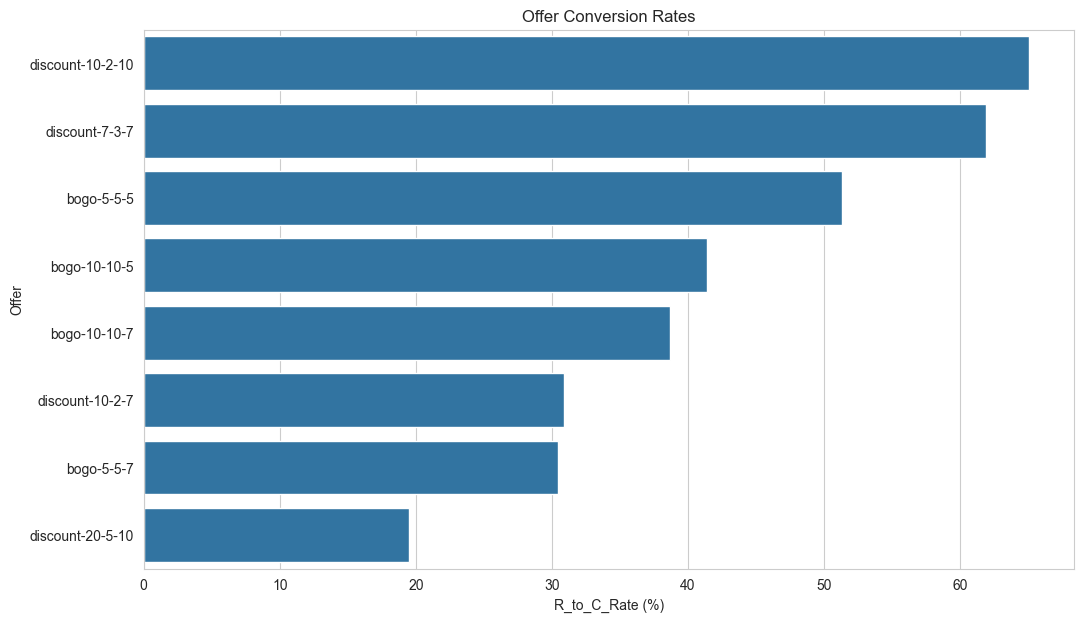

In [44]:
# Now plot R_to_c Rate
plt.figure(figsize=(12, 7))
sns.barplot(data=df_offer_performance.reset_index(), x='R_to_C_Rate (%)', y='offer_key')
plt.title('Offer Conversion Rates')
plt.xlabel('R_to_C_Rate (%)')
plt.ylabel('Offer')
plt.show()

### 4.3: Channel Performance (Conversion Rate)
Now I will check channel performance to validate the offer performance results. Where are the problems? whether it is in channels or offer?

In [45]:
# 1. Get channel completed performance from df_final
channel_completed = df_final['channels'].value_counts()
# 2. get received amount from df_offer_received
channel_received=df_offer_received['channels'].value_counts()
#3. get viewed amount from df_offer_received
channel_viewed=df_offer_viewed['channels'].value_counts()
#4. Create dataframe 
df_channel_conversion = pd.DataFrame({'Received': channel_received, 'viewed': channel_viewed, 'completions': channel_completed})
# 4. Calculate Conversion Rate
df_channel_conversion['R to V Rate'] = ((df_channel_conversion['viewed'] / df_channel_conversion['Received']) * 100).round(2).astype(str) + '%'
df_channel_conversion['V to C Rate'] = ((df_channel_conversion['completions'] / df_channel_conversion['viewed']) * 100).round(2).astype(str) + '%'
df_channel_conversion['R to C Rate'] = ((df_channel_conversion['completions'] / df_channel_conversion['Received']) * 100).round(2).astype(str) + '%'

df_channel_conversion = df_channel_conversion.sort_values('R to C Rate', ascending=False)
print("--- Channel Conversion Rates ---")
df_channel_conversion


--- Channel Conversion Rates ---


,Received,viewed,completions,R to V Rate,V to C Rate,R to C Rate
channels,,,,,,
"['web', 'email', 'mobile', 'social']",26476,25384,14553,95.88%,57.33%,54.97%
"['email', 'mobile', 'social']",6683,5901,2585,88.3%,43.81%,38.68%
"['web', 'email', 'mobile']",13316,6964,4084,52.3%,58.64%,30.67%
"['web', 'email']",6726,2275,1311,33.82%,57.63%,19.49%


**Comment**
This data proves that 'mobile' and 'social' are the two most critical channels for marketing visibility.The primary marketing goal should be to migrate all customers onto all four channels

### 4.4: Demographic Performance



### 4.4.1.: Who are our best customers?

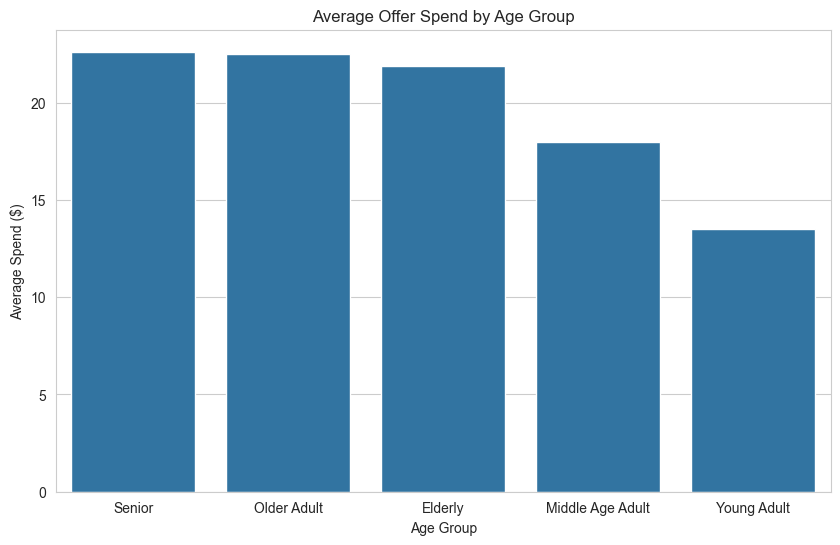

--- Analysis by Age Group (Offer Completions) ---
                  count          sum    mean
age_group                                   
Senior             4947  $111,882.33  $22.62
Older Adult        8258  $185,998.16  $22.52
Elderly            1808   $39,608.99  $21.91
Middle Age Adult   4918   $88,471.96  $17.99
Young Adult        2602   $35,169.31  $13.52


In [46]:
#1. --- Analyze by Age Group ---
age_analysis = df_final.groupby('age_group')['transaction_amount'].agg(['count', 'sum', 'mean'])
age_analysis = age_analysis.sort_values('mean', ascending=False)
# Plot for Age
plt.figure(figsize=(10, 6))
sns.barplot(data=age_analysis.reset_index(), x='age_group', y='mean')
plt.title('Average Offer Spend by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Spend ($)')
plt.show()

#create dataframe for age analysis in proper format
age_analysis['sum'] = age_analysis['sum'].map('${:,.2f}'.format)
age_analysis['mean'] = age_analysis['mean'].map('${:,.2f}'.format)

print("--- Analysis by Age Group (Offer Completions) ---")
print(age_analysis)

**Comment:** Senior, Older Adult, and Elderly customers are the premium segment. They spend an average of $22 per successful offer. They are high-value and reliable.

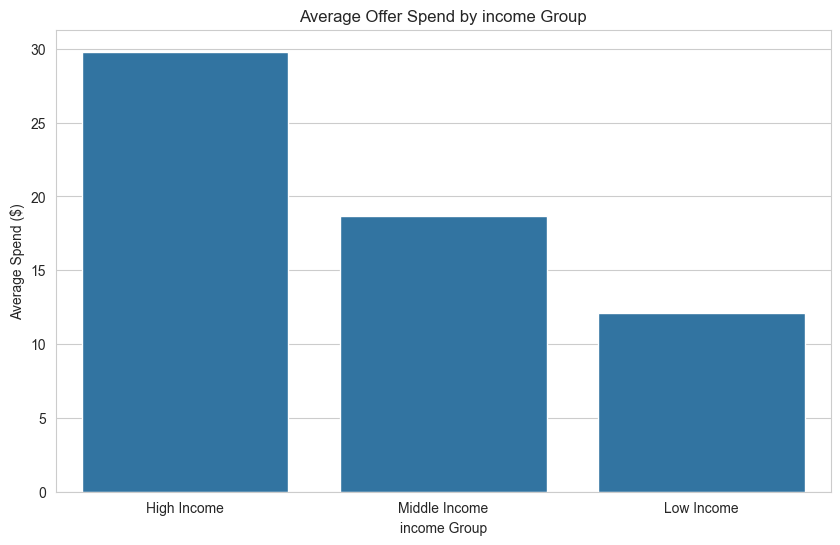


--- Analysis by Income Group (Offer Completions) ---
               count          sum    mean
income_group                             
High Income     5455  $162,555.71  $29.80
Middle Income  14030  $261,636.93  $18.65
Low Income      3048   $36,938.11  $12.12


In [47]:
#2. --- Analyze by Income Group ---
income_analysis = df_final.groupby('income_group')['transaction_amount'].agg(['count', 'sum', 'mean'])
income_analysis = income_analysis.sort_values('mean', ascending=False)
# Plot for Age
plt.figure(figsize=(10, 6))
sns.barplot(data=income_analysis.reset_index(), x='income_group', y='mean')
plt.title('Average Offer Spend by income Group')
plt.xlabel('income Group')
plt.ylabel('Average Spend ($)')
plt.show()

#create data frame with proper formating
income_analysis['sum'] = income_analysis['sum'].map('${:,.2f}'.format)
income_analysis['mean'] = income_analysis['mean'].map('${:,.2f}'.format)

print("\n--- Analysis by Income Group (Offer Completions) ---")
print(income_analysis)

**Comment**
High income group tend to spend more per transaction.

In [48]:
#3. --- Analyze by Gender ---
gender_analysis = df_final.groupby('gender')['transaction_amount'].agg(['count', 'sum', 'mean'])
gender_analysis = gender_analysis.sort_values('mean', ascending=False)
gender_analysis['sum'] = gender_analysis['sum'].map('${:,.2f}'.format)
gender_analysis['mean'] = gender_analysis['mean'].map('${:,.2f}'.format)

print("\n--- Analysis by Gender (Offer Completions) ---")
print(gender_analysis)


--- Analysis by Gender (Offer Completions) ---
        count          sum    mean
gender                            
F       10500  $235,064.10  $22.39
O         389    $7,536.91  $19.38
M       11644  $218,529.74  $18.77


**Comment**
Female spend more per transaction compared to men.




### 4.4.2.: What offer they respond?

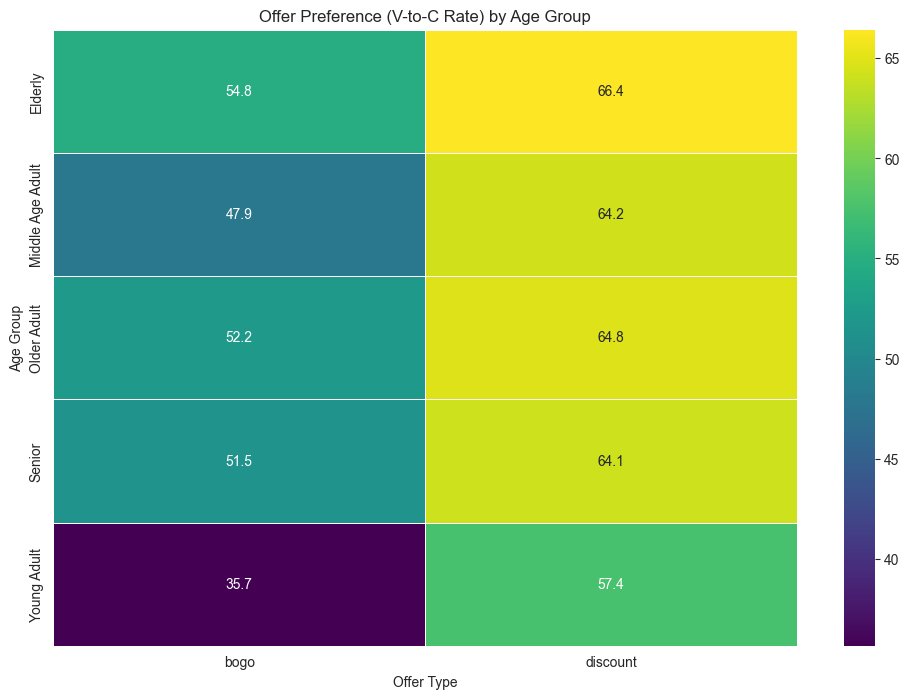

--- View-to-Completion (Persuasion) Rate (%) by Age Group ---
offer_type         bogo  discount
age_group                        
Elderly          54.77%    66.42%
Middle Age Adult 47.92%    64.19%
Older Adult      52.19%    64.77%
Senior           51.46%    64.09%
Young Adult      35.66%    57.43%


In [49]:
# 1. Get total VIEWED offers by segment and type
viewed_by_segment = df_offer_viewed.groupby(['age_group', 'offer_type']).size().unstack().fillna(0)

# 2. Get total COMPLETED offers by segment and type
completed_by_segment = df_final.groupby(['age_group', 'offer_type']).size().unstack().fillna(0)

# 3. Calculate the View-to-Completion (V-to-C) Rate
# This is your "Preference" or "Persuasion" matrix
preference_rate = (completed_by_segment / viewed_by_segment) * 100

# 4. Plot the preference rate as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    preference_rate, 
    annot=True, 
    fmt='.1f',  # Format as one decimal place
    cmap='viridis',
    linewidths=.5
)
plt.title('Offer Preference (V-to-C Rate) by Age Group')
plt.xlabel('Offer Type')
plt.ylabel('Age Group')
plt.show()

# Print the raw rate table
print("--- View-to-Completion (Persuasion) Rate (%) by Age Group ---")
print(preference_rate.to_string(float_format='{:.2f}%'.format))

**Comment**:

Discount offers are significantly more persuasive than BOGO offers across all age groups.